In [57]:
import torch
import numpy as np
from torchvision.models import alexnet
np.random.seed(1234)
torch.random.manual_seed(1234)

In [58]:
from torch import nn
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights
from torchvision.models import resnet18, ResNet18_Weights
def get_squeezenet(num_class=16):
  model = squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT)
  model.classifier[1] = nn.Conv2d(512, num_class, kernel_size=(1, 1), stride=(1, 1))
  model.num_classes = num_class
  return model

def get_resnet(num_class=16):
  model = resnet18(weights=ResNet18_Weights.DEFAULT)
  model.fc = nn.Linear(512, num_class)
  return model


In [59]:
classes = {
  'Annunciazione': 0,
  'Libro d\'Ore miniato': 1,
  'Lastra tombale di Giovanni Cabastida': 2,
  'Madonna del Cardillo': 3,
  'Disputa di San Tommaso': 4,
  'Traslazione della Santa Casa': 5,
  'Madonna col Bambino': 6,
  'L\'immacolata Concezione e Dio Padre in Gloria': 7,
  'Adorazione dei Magi': 8,
  'Sant\'Elena e Costantino e Madonna con Bambino in gloria fra angeli': 9,
  'Taccuini di disegni': 10,
  'Martirio di S. Lucia': 11,
  'Volto di Cristo': 12,
  'Dipinti di Sant\'Orsola': 13,
  'Immacolata e i santi Chiara, Francesco, Antonio, Abate, Barbara e Maria Maddalena': 14,
  'Storia della Genesi': 15
}

In [60]:
import json
import pandas as pd

# synthetic
jsonSyntheticTrain = json.load(open('../data/MDA_Bellomo/Synthetic/Object_annotations/Training_annotations.json'))
dfImagesSyntheticTrain = pd.DataFrame(jsonSyntheticTrain['images'])
dfAnnotationsSyntheticTrain = pd.DataFrame(jsonSyntheticTrain['annotations'])

jsonSyntheticTest = json.load(open('../data/MDA_Bellomo/Synthetic/Object_annotations/TestSet_annotations.json'))
dfImagesSyntheticTest = pd.DataFrame(jsonSyntheticTest['images'])
dfAnnotationsSyntheticTest = pd.DataFrame(jsonSyntheticTest['annotations'])

jsonSyntheticVal = json.load(open('../data/MDA_Bellomo/Synthetic/Object_annotations/ValidSet_annotations.json'))
dfImagesSyntheticVal = pd.DataFrame(jsonSyntheticVal['images'])
dfAnnotationsSyntheticVal = pd.DataFrame(jsonSyntheticVal['annotations'])

# gopro
jsonGoProTrain = json.load(open('../data/MDA_Bellomo/GoPro/Train/training_set.json'))
dfImagesGoProTrain = pd.DataFrame(jsonGoProTrain['images'])
dfAnnotationsGoProTrain = pd.DataFrame(jsonGoProTrain['annotations'])

jsonGoProTest = json.load(open('../data/MDA_Bellomo/GoPro/Test/test_set.json'))
dfImagesGoProTest = pd.DataFrame(jsonGoProTest['images'])
dfAnnotationsGoProTest = pd.DataFrame(jsonGoProTest['annotations'])

# hololens
jsonHololensTrain = json.load(open('../data/MDA_Bellomo/Hololens/Train/training_set.json'))
dfImagesHololensTrain = pd.DataFrame(jsonHololensTrain['images'])
dfAnnotationsHololensTrain = pd.DataFrame(jsonHololensTrain['annotations'])

jsonHololensTest = json.load(open('../data/MDA_Bellomo/Hololens/Test/test_set.json'))
dfImagesHololensTest = pd.DataFrame(jsonHololensTest['images'])
dfAnnotationsHololensTest = pd.DataFrame(jsonHololensTest['annotations'])




In [61]:
# for every image crop at the bounding box and save it in a new folder
from PIL import Image
from tqdm import tqdm
import re

def cropSet(dfImages, dfAnnotations, cameraType, set):
    for row in tqdm(dfImages.iterrows()):
        globalImagePath = f'../data/MDA_Bellomo/{cameraType}/'
        if cameraType == 'Synthetic':
                globalImagePath += 'images'
        else:
            globalImagePath += f'{set}'
        for row2 in dfAnnotations[dfAnnotations['image_id'] == row[1]['id']].iterrows():
            imagePath = globalImagePath + '/' + row[1]['file_name']
            image = Image.open(imagePath)
            imageName = row[1]['file_name']
            imageName = re.sub('/', '_' , imageName)
            bbox = row2[1]['bbox']
            if(bbox[2] <= 1 or bbox[3] <= 1):
                break
            left = bbox[0]
            top = bbox[1]
            right = bbox[0] + bbox[2]
            bottom = bbox[1] + bbox[3]
            if right >= image.width:
                right = image.width-1
            if bottom >= image.height:
                bottom = image.height-1

            cropped = image.crop((left, top, right, bottom))
            
            cropped.save(f'../data/cropped_Datasets/{cameraType}/{set}/{str(row2[1]["category_id"])}/'+imageName+'_' +str(row2[1]['category_id']) + '.jpg')

# cropSet(dfImagesSyntheticTrain, dfAnnotationsSyntheticTrain, 'Synthetic', 'Train')
# cropSet(dfImagesSyntheticVal, dfAnnotationsSyntheticVal, 'Synthetic', 'Val')
# cropSet(dfImagesSyntheticTest, dfAnnotationsSyntheticTest, 'Synthetic', 'Test')

# cropSet(dfImagesGoProTrain, dfAnnotationsGoProTrain, 'GoPro', 'Train')
# cropSet(dfImagesGoProTest, dfAnnotationsGoProTest, 'GoPro', 'Test')

# cropSet(dfImagesHololensTrain, dfAnnotationsHololensTrain, 'Hololens', 'Train')
# cropSet(dfImagesHololensTest, dfAnnotationsHololensTest, 'Hololens', 'Test')



In [62]:
from torchvision import transforms
train_transform = transforms.Compose([
 transforms.Resize(256),
 transforms.RandomCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ])

test_transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(),
 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
 ])


In [63]:
print(torch.cuda.is_available())

False


In [64]:

from torchvision import datasets
from torch.utils.data import ConcatDataset, random_split

image_datasets = {
    'train': datasets.ImageFolder('../data/cropped_Datasets/Synthetic/Train', train_transform),
    'val': datasets.ImageFolder('../data/cropped_Datasets/Synthetic/Val', test_transform),
    'test': datasets.ImageFolder('../data/cropped_Datasets/Synthetic/Test', test_transform),
    'HoloTrain': datasets.ImageFolder('../data/cropped_Datasets/Hololens/Train', train_transform),
    'GoproTrain': datasets.ImageFolder('../data/cropped_Datasets/GoPro/Train', train_transform),
    'HoloTest': datasets.ImageFolder('../data/cropped_Datasets/Hololens/Test', test_transform),
    'GoProTest': datasets.ImageFolder('../data/cropped_Datasets/GoPro/Test', test_transform),
    'HoloGoProTrain': ConcatDataset([datasets.ImageFolder('../data/cropped_Datasets/Hololens/Train', train_transform), datasets.ImageFolder('../data/cropped_Datasets/GoPro/Train', train_transform)]),
    'HoloGoProTest': ConcatDataset([datasets.ImageFolder('../data/cropped_Datasets/Hololens/Test', test_transform), datasets.ImageFolder('../data/cropped_Datasets/GoPro/Test', test_transform)])
}

image_datasets['HoloGoProTrain'], image_datasets['HoloGoProVal'] = random_split(image_datasets['HoloGoProTrain'], [int(len(image_datasets['HoloGoProTrain']) * 0.8), int(len(image_datasets['HoloGoProTrain']) * 0.2)])

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=4, shuffle=True, num_workers=4),
    'HoloTrain': torch.utils.data.DataLoader(image_datasets['HoloTrain'], batch_size=4, shuffle=True, num_workers=4),
    'GoproTrain': torch.utils.data.DataLoader(image_datasets['GoproTrain'], batch_size=4, shuffle=True, num_workers=4),
    'HoloTest': torch.utils.data.DataLoader(image_datasets['HoloTest'], batch_size=4, shuffle=True, num_workers=4),
    'GoProTest': torch.utils.data.DataLoader(image_datasets['GoProTest'], batch_size=4, shuffle=True, num_workers=4),
    'HoloGoProTrain': torch.utils.data.DataLoader(image_datasets['HoloGoProTrain'], batch_size=4, shuffle=True, num_workers=4),
    'HoloGoProVal': torch.utils.data.DataLoader(image_datasets['HoloGoProVal'], batch_size=4, shuffle=True, num_workers=4),
    'HoloGoProTest': torch.utils.data.DataLoader(image_datasets['HoloGoProTest'], batch_size=4, shuffle=True, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test', 'HoloTest', 'GoProTest', 'HoloTrain', 'GoproTrain', 'HoloGoProTrain', 'HoloGoProVal', 'HoloGoProTest']}

In [65]:
import os
from tempfile import TemporaryDirectory
import time
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

global_step = 0
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_loader='train', val_loader='val'):
    global global_step
    since = time.time()

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join('./weights/', 'best_model_params_squeeze_mix.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_loader, val_loader]:
            if phase == train_loader:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_loader):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_loader:
                        writer.add_scalar("Loss/train", loss, global_step=global_step)
                        writer.add_scalar("Accuracy/train", accuracy_score(labels.cpu(), preds.cpu()), global_step=global_step)
                        loss.backward()
                        optimizer.step()
                        global_step += 1
                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == train_loader:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == val_loader:
                writer.add_scalar("Loss/test", epoch_loss, global_step=epoch)
                writer.add_scalar("Accuracy/test", epoch_acc, global_step=epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == val_loader and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model

In [66]:

import torch.optim as optim
from torch.optim import lr_scheduler
squeezenet_Bellomo = get_squeezenet()
squeezenet_Bellomo = squeezenet_Bellomo.to(device)

resnet18_Bellomo = get_resnet()
resnet18_Bellomo = resnet18_Bellomo.to(device)

current_model = resnet18_Bellomo

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(current_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [67]:
squeezenet_caltech101_finetuned = train_model(
    current_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, train_loader='HoloGoProTrain', val_loader='HoloGoProVal'
)

Epoch 0/9
----------
HoloGoProTrain Loss: 1.3779 Acc: 0.5852
HoloGoProVal Loss: 0.7008 Acc: 0.8106

Epoch 1/9
----------
HoloGoProTrain Loss: 0.8360 Acc: 0.7592
HoloGoProVal Loss: 0.4844 Acc: 0.8561

Epoch 2/9
----------
HoloGoProTrain Loss: 0.6677 Acc: 0.8087
HoloGoProVal Loss: 0.4269 Acc: 0.8826

Epoch 3/9
----------
HoloGoProTrain Loss: 0.5750 Acc: 0.8346
HoloGoProVal Loss: 0.3815 Acc: 0.8902

Epoch 4/9
----------
HoloGoProTrain Loss: 0.5143 Acc: 0.8520
HoloGoProVal Loss: 0.3481 Acc: 0.9053

Epoch 5/9
----------
HoloGoProTrain Loss: 0.4407 Acc: 0.8703
HoloGoProVal Loss: 0.3243 Acc: 0.9167

Epoch 6/9
----------
HoloGoProTrain Loss: 0.4196 Acc: 0.8734
HoloGoProVal Loss: 0.2804 Acc: 0.9167

Epoch 7/9
----------
HoloGoProTrain Loss: 0.2900 Acc: 0.9132
HoloGoProVal Loss: 0.2683 Acc: 0.9242

Epoch 8/9
----------
HoloGoProTrain Loss: 0.2530 Acc: 0.9274
HoloGoProVal Loss: 0.2670 Acc: 0.9230

Epoch 9/9
----------
HoloGoProTrain Loss: 0.2592 Acc: 0.9249
HoloGoProVal Loss: 0.2926 Acc: 0.9192



In [80]:
from numpy import argmax


y_pred = {
        'test': [],
        'HoloTest': [],
        'GoProTest': []
}

y_true = {
        'test': [],
        'HoloTest': [],
        'GoProTest': []
}


current_model.load_state_dict(torch.load('./weights/best_model_params.pt')) # Load Model
current_model.eval() # Set model to evaluation mode

with torch.no_grad():
        for cameraBatch in ['HoloTest', 'GoProTest']:
                print(f'Camera Batch: {cameraBatch}\n -------------------')
                for i, (x, y) in enumerate(dataloaders[cameraBatch]):
                        x = x.to(device)
                        y = y.to(device)
                        outputs = current_model(x)
                        _, predicted_labels = torch.max(outputs, 1)
                        y_pred[cameraBatch].extend(predicted_labels.cpu().detach().numpy())
                        y_true[cameraBatch].extend(y.cpu().detach().numpy())
                        print(f'Batch: {i+1}/{len(dataloaders[cameraBatch])}', end='\r')

                y_pred[cameraBatch] = np.array(y_pred[cameraBatch])
                y_true[cameraBatch] = np.array(y_true[cameraBatch])




        




Camera Batch: HoloTest
 -------------------


Camera Batch: GoProTest
 -------------------


In [74]:
print(y_pred['HoloTest'][1])
print('---')
print(y_true['HoloTest'][1])

11
---
11


In [75]:
for cameraBatch in ['test', 'HoloTest', 'GoProTest']:
    y_pred[cameraBatch] = torch.tensor(y_pred[cameraBatch]).to(device)
    y_true[cameraBatch] = torch.tensor(y_true[cameraBatch]).to(device)

HoloTest


Accuracy: 0.9220430107526881
Precision: 0.9244977752140424
Recall: 0.9066994450071462
F1 score: 0.9106219436392387
--------------------
GoProTest


Accuracy: 0.9406150583244963
Precision: 0.9379895904431628
Recall: 0.9370423343234536
F1 score: 0.9345309466648397
--------------------


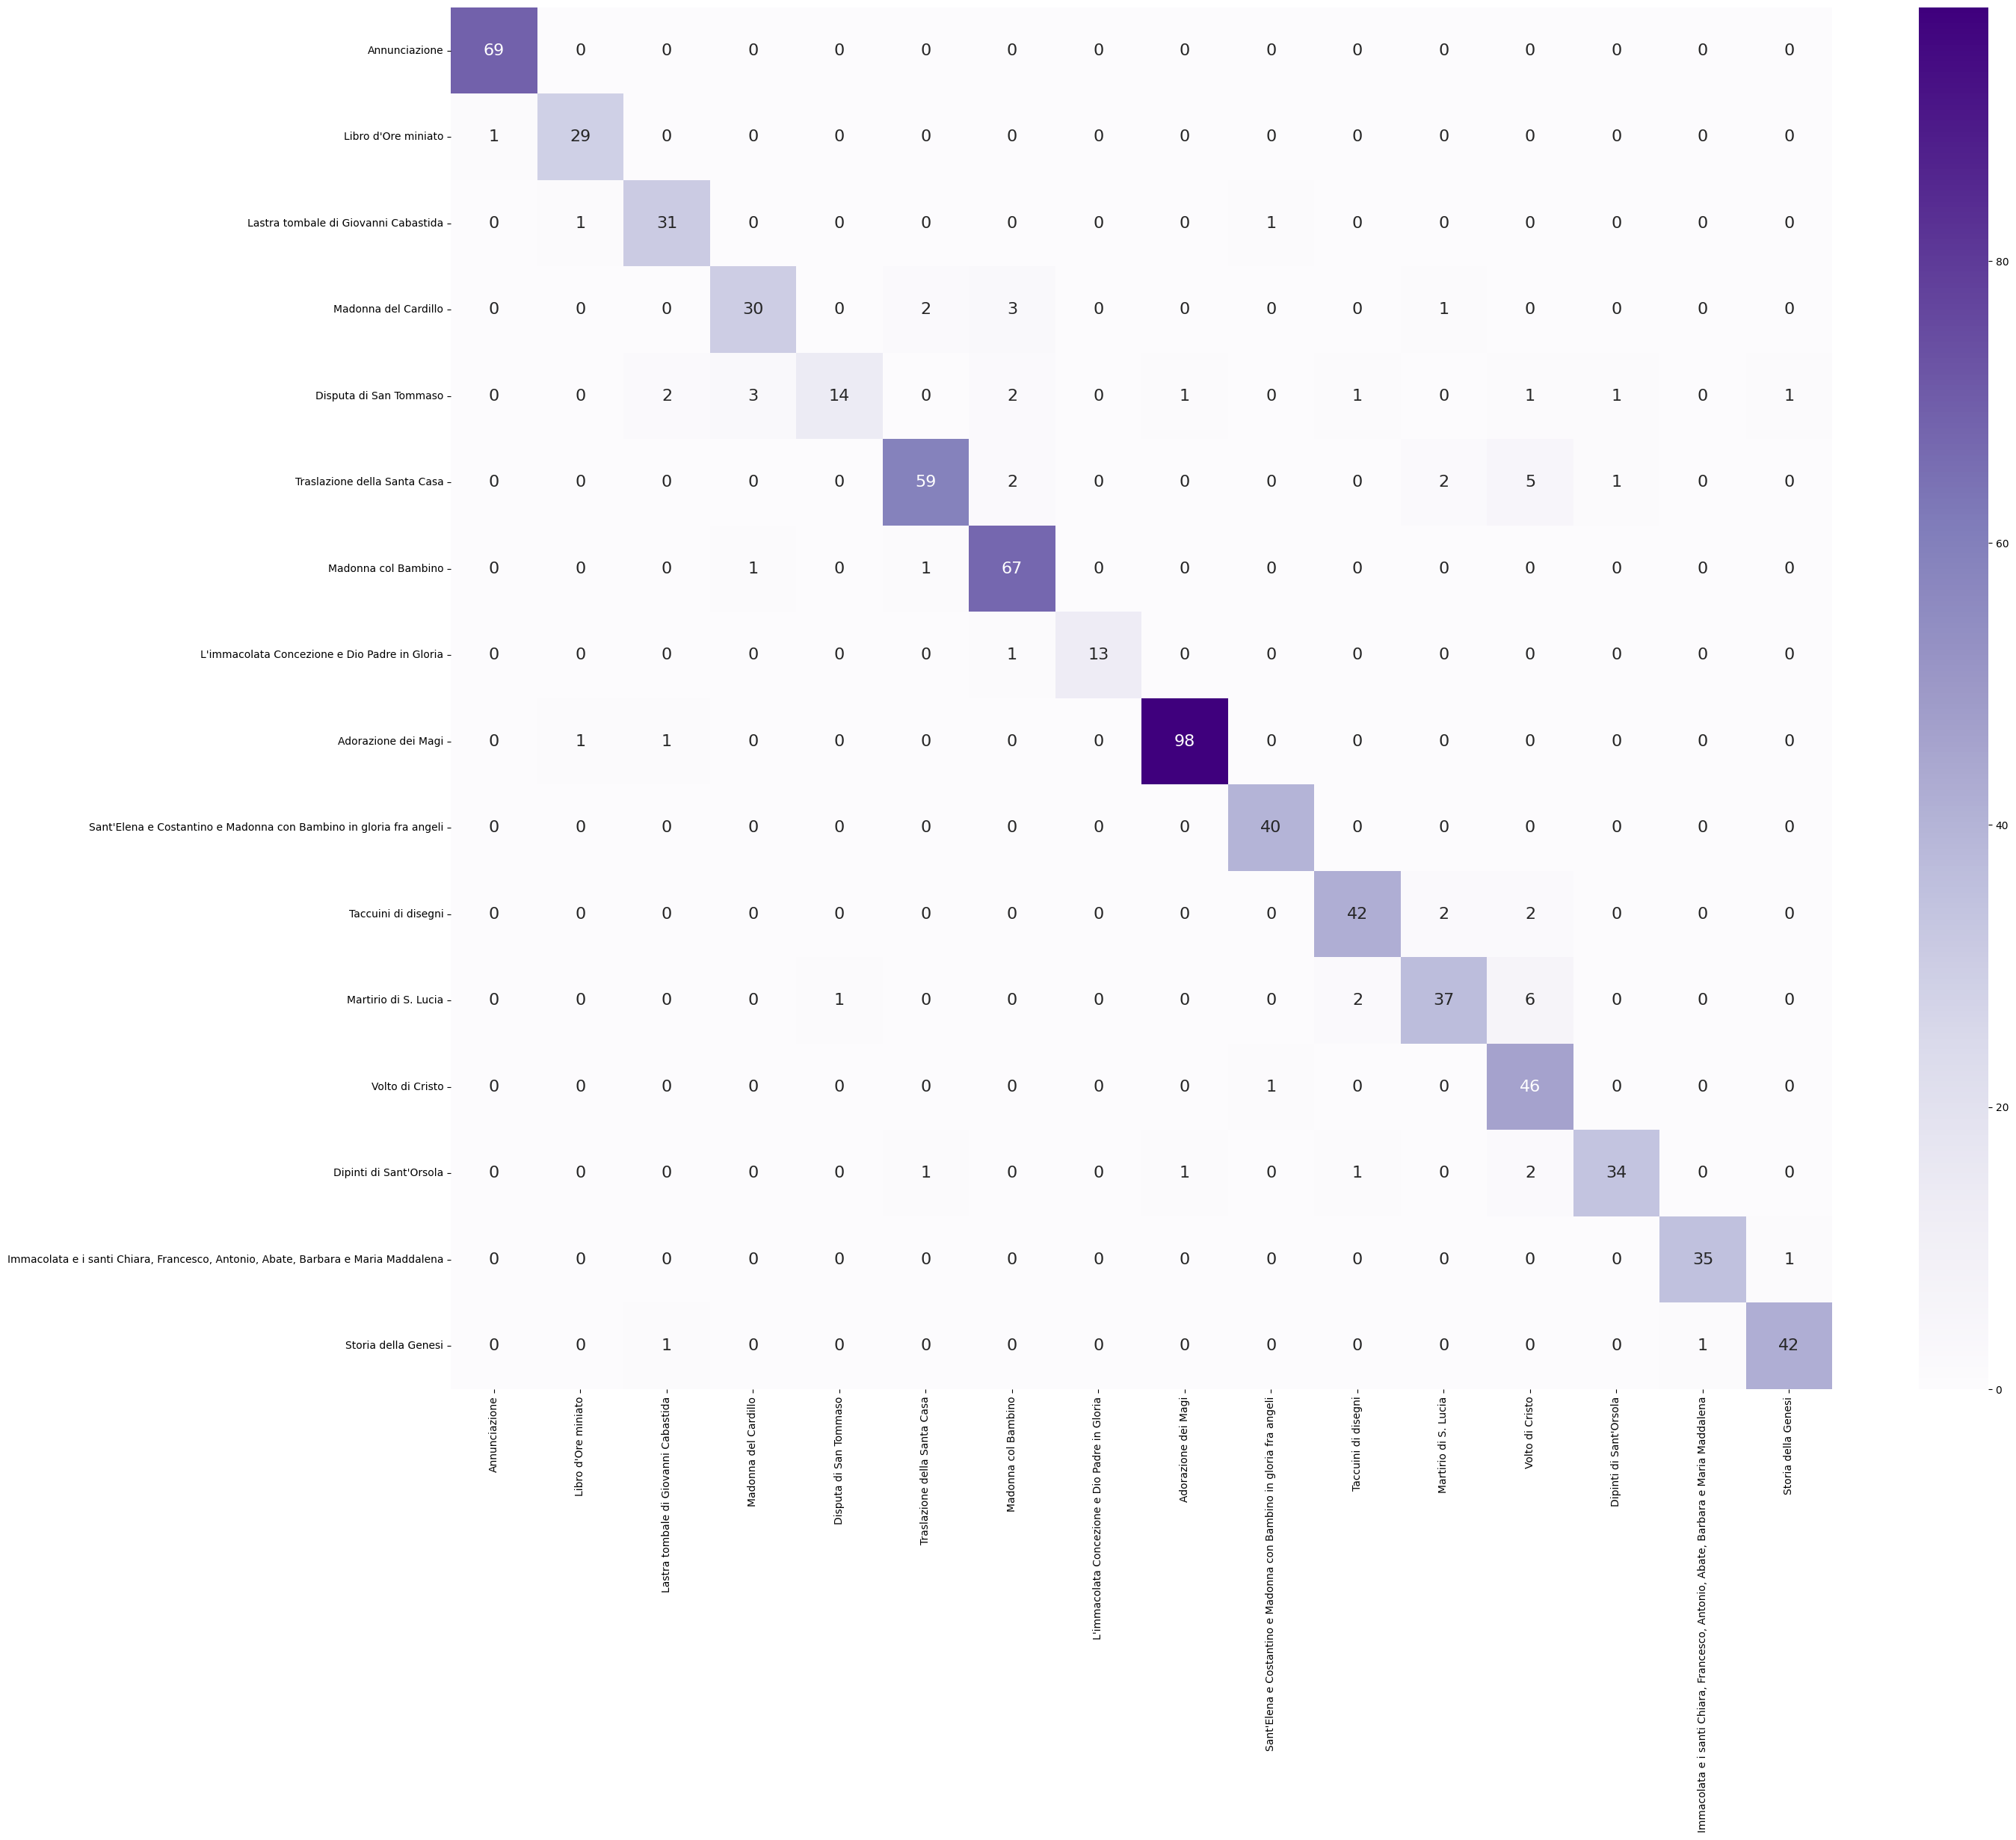

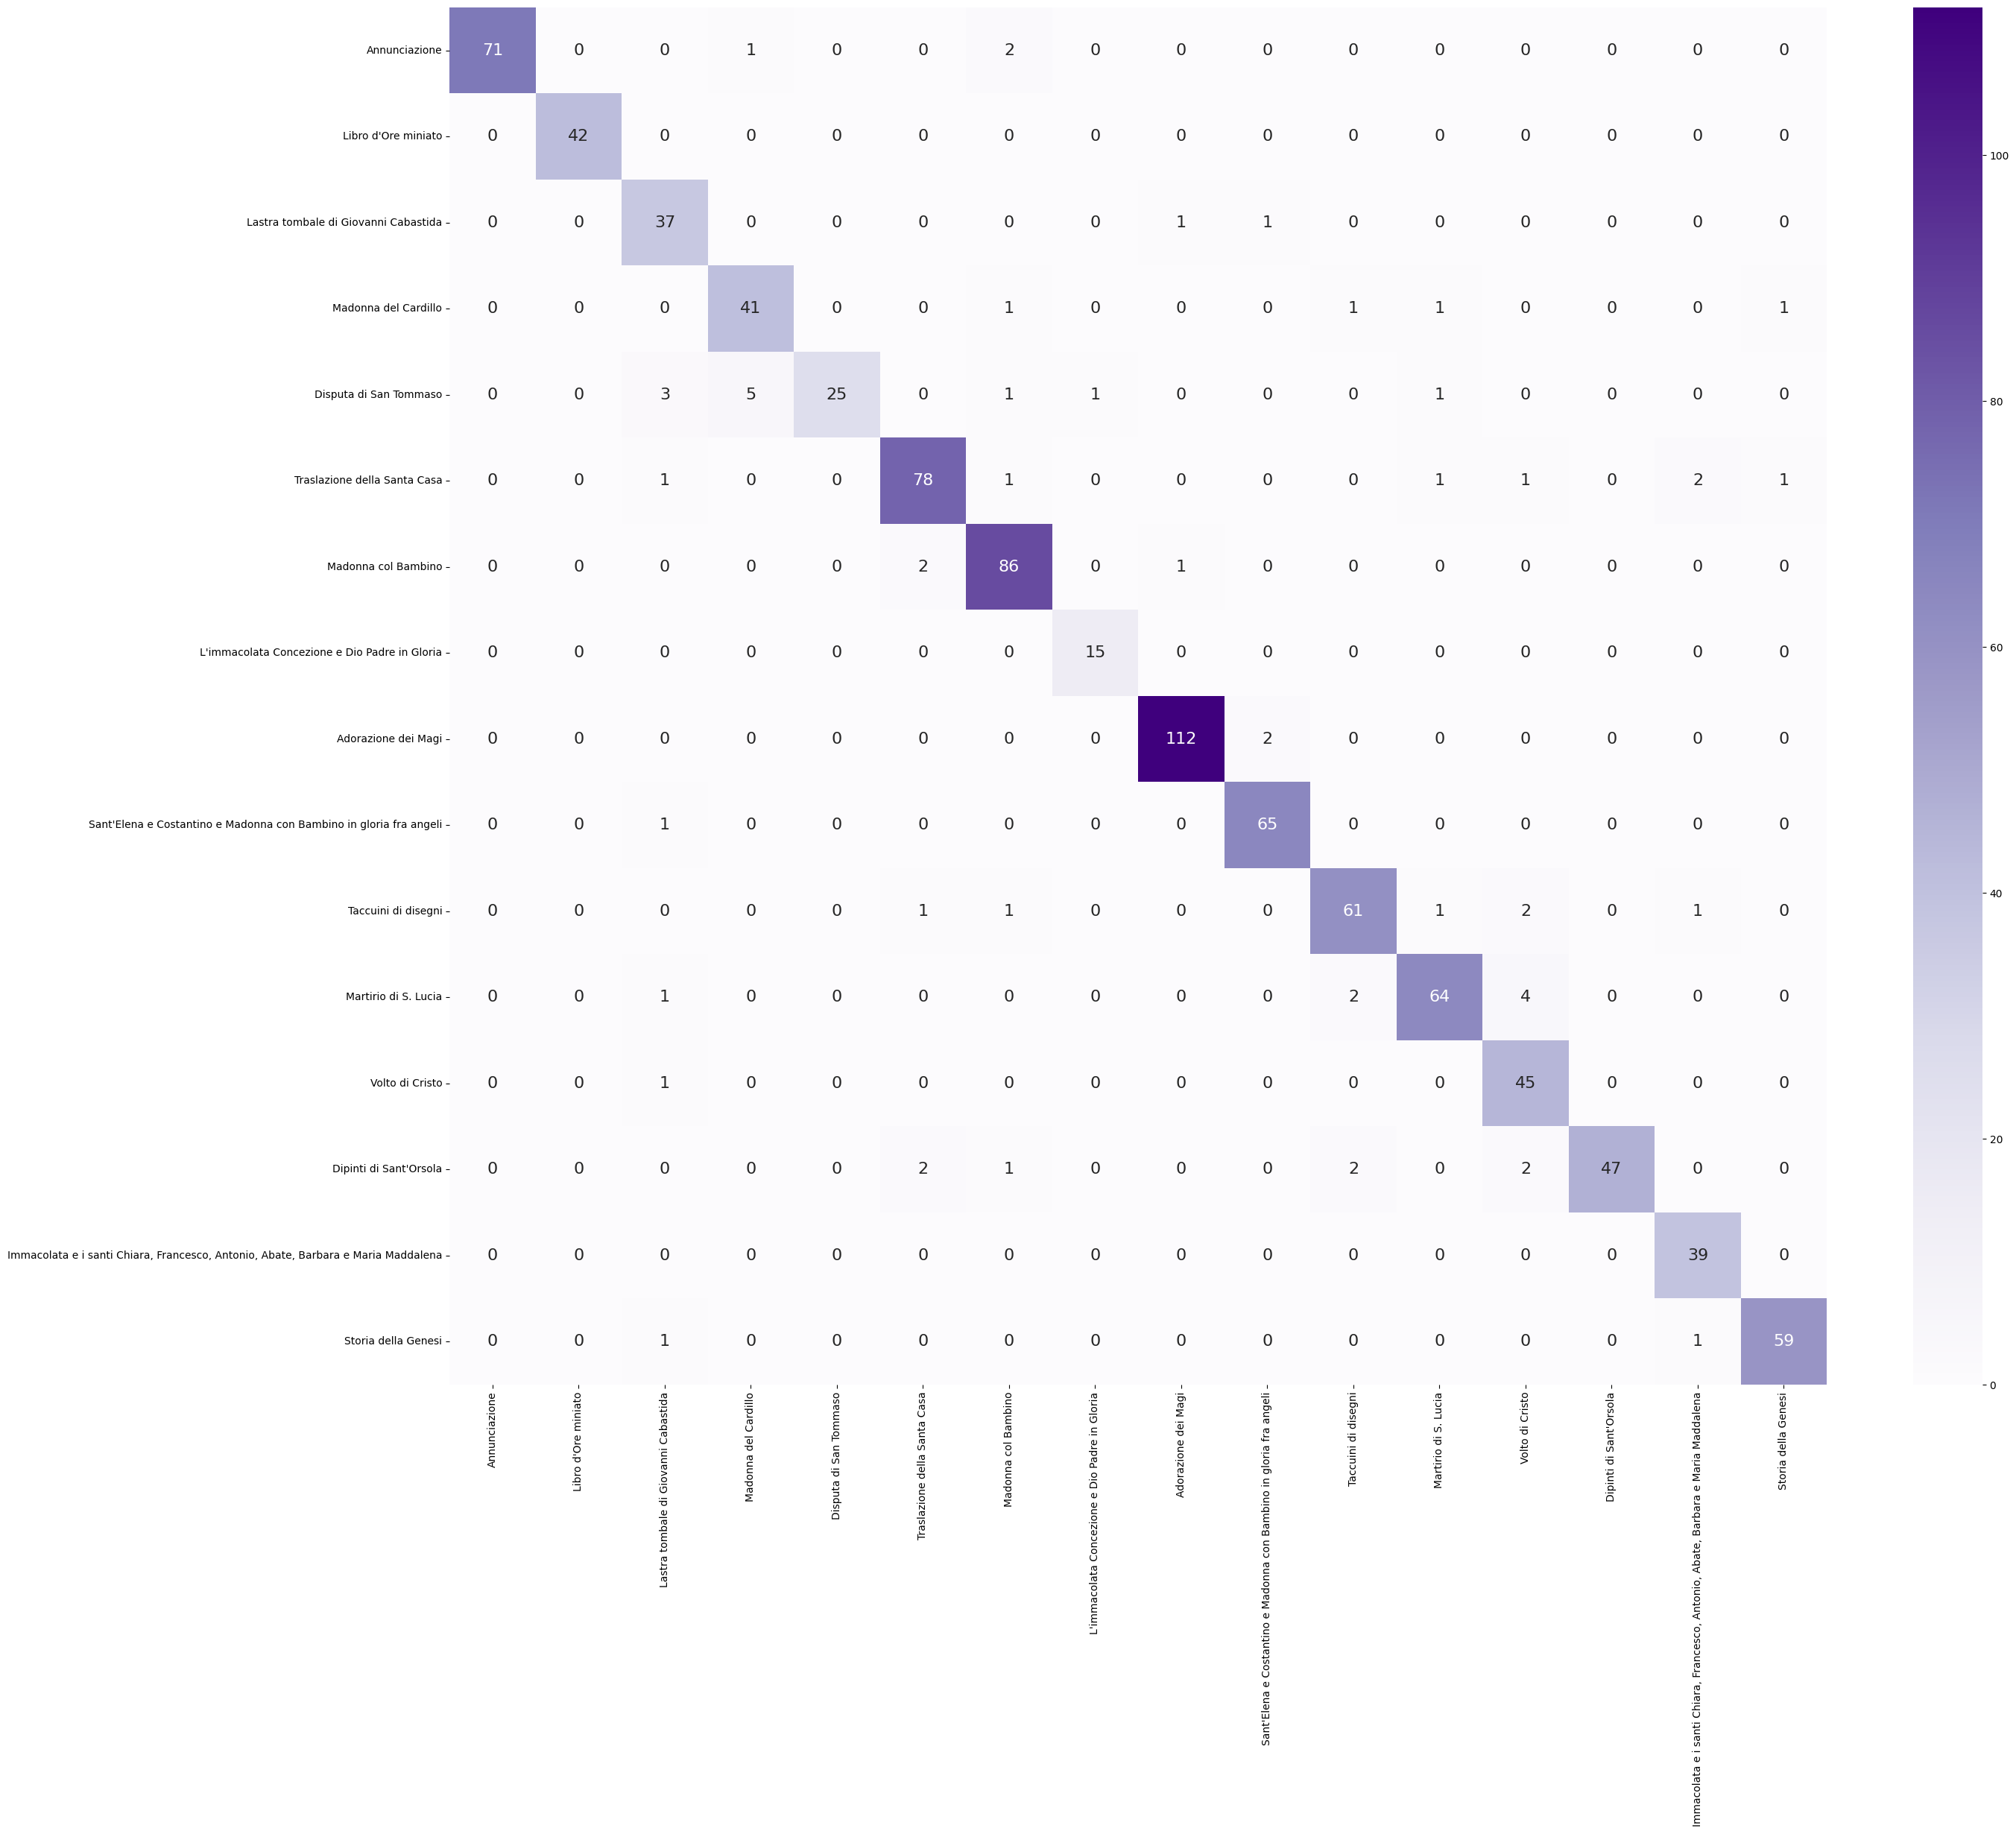

In [84]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

current_model.load_state_dict(torch.load('./weights/best_model_params.pt')) # Load Model

for cameraBatch in ['HoloTest', 'GoProTest']:
      cf_matrix = confusion_matrix(y_true[cameraBatch], y_pred[cameraBatch])

      print(cameraBatch)
      print('\n')

      plt.figure(figsize = (30,24))
      sn.heatmap(cf_matrix, annot=True, cmap='Purples', square=True, fmt='g', annot_kws={"size": 16}, xticklabels=classes.keys(), yticklabels=classes.keys())
      plt.savefig(f'output{cameraBatch}.png')

      accuracy = accuracy = np.trace(cf_matrix) / np.sum(cf_matrix)
      print(f'Accuracy: {accuracy}')

      precision = precision_score(y_true[cameraBatch], y_pred[cameraBatch], average='macro')
      print(f'Precision: {precision}')

      recall = recall_score(y_true[cameraBatch], y_pred[cameraBatch], average='macro')
      print(f'Recall: {recall}')

      f1 = f1_score(y_true[cameraBatch], y_pred[cameraBatch], average='macro')
      print(f'F1 score: {f1}')

      print('-'*20)


            

